<a href="https://colab.research.google.com/github/MasahiroAraki/MLCourse/blob/master/13_struct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第13章 系列データの識別

## 構造化データ学習のためのライブラリ PyStruct

http://pystruct.github.io/

In [1]:
# colabで実行
!pip install pystruct
import pkg_resources, imp
imp.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py'>

PyStructのサイトで紹介されている英単語手書き文字系列の認識をやってみます。英小文字をクラスとしているので、単語の最初の文字（大文字）を削除しているという特殊な設定です。

https://pystruct.github.io/auto_examples/plot_letters.html#sphx-glr-auto-examples-plot-letters-py

ライブラリの読み込み

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC

from pystruct.datasets import load_letters
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


正解の表示のために、整数で表された正解データと文字との対応を取るための変数を定義します。

In [3]:
abc = "abcdefghijklmnopqrstuvwxyz"

データの読み込み

各事例は、文字数×128(縦16、横8のバイナリ(0,1)画像をフラットにしたもの）のndarrayです。同じ単語について、異なる人が書いた事例が10事例前後並んでおり、各事例にはデータ分割用の情報folds（0から9の整数値）が付いています。

In [4]:
letters = load_letters()
X, y, folds = letters['data'], letters['labels'], letters['folds']
X, y = np.array(X), np.array(y)
X_train, X_test = X[folds == 1], X[folds != 1]
y_train, y_test = y[folds == 1], y[folds != 1]

比較用に、各画像単独で scikit-learnのSVCで学習します。

In [5]:
# Train linear SVM
svm = LinearSVC(dual=False, C=.1)
# flatten input
svm.fit(np.vstack(X_train), np.hstack(y_train))

LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

構造化SVMで学習します。

In [6]:
# Train linear chain CRF
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=11)
ssvm.fit(X_train, y_train)

FrankWolfeSSVM(C=0.1, batch_mode=False, check_dual_every=10, do_averaging=True,
               line_search=True, logger=None, max_iter=11,
               model=ChainCRF(n_states: 26, inference_method: max-product),
               n_jobs=1, random_state=None, sample_method='perm',
               show_loss_every=0, tol=0.001, verbose=0)

構造化の有無で性能を比較します。

In [7]:
print("Test score with chain CRF: %f" % ssvm.score(X_test, y_test))

print("Test score with linear SVM: %f" % svm.score(np.vstack(X_test),
                                                   np.hstack(y_test)))

Test score with chain CRF: 0.786327
Test score with linear SVM: 0.713812


テストデータからランダムに選んで、画像、正解（左上）、単独（左下）、構造化（右下）を表示します。表示する文字列はRandomStateの値で変えることができます。

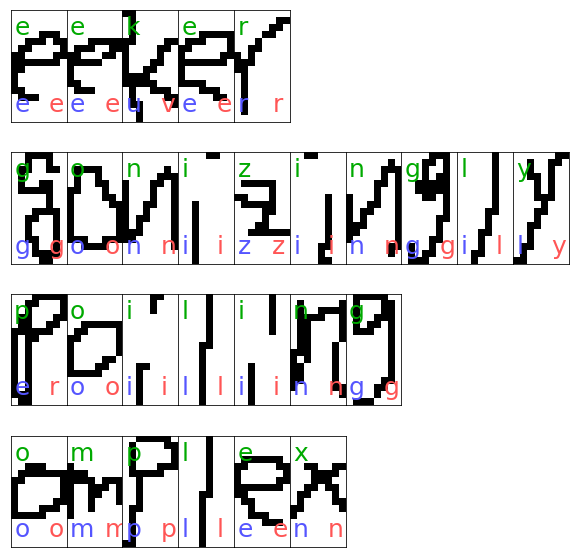

In [8]:
# plot some word sequenced
n_words = 4
rnd = np.random.RandomState(5)
selected = rnd.randint(len(y_test), size=n_words)
max_word_len = max([len(y_) for y_ in y_test[selected]])
fig, axes = plt.subplots(n_words, max_word_len, figsize=(10, 10))
fig.subplots_adjust(wspace=0)
for ind, axes_row in zip(selected, axes):
    y_pred_svm = svm.predict(X_test[ind])
    y_pred_chain = ssvm.predict([X_test[ind]])[0]
    for i, (a, image, y_true, y_svm, y_chain) in enumerate(
            zip(axes_row, X_test[ind], y_test[ind], y_pred_svm, y_pred_chain)):
        a.matshow(image.reshape(16, 8), cmap=plt.cm.Greys)
        a.text(0, 3, abc[y_true], color="#00AA00", size=25)
        a.text(0, 14, abc[y_svm], color="#5555FF", size=25)
        a.text(5, 14, abc[y_chain], color="#FF5555", size=25)
        a.set_xticks(())
        a.set_yticks(())
    for ii in range(i + 1, max_word_len):
        axes_row[ii].set_visible(False)

#plt.matshow(ssvm.w[26 * 8 * 16:].reshape(26, 26))
#plt.colorbar()
#plt.title("Transition parameters of the chain CRF.")
#plt.xticks(np.arange(25), abc)
#plt.yticks(np.arange(25), abc)
#plt.show()

## 課題1

上記コードはPyStructのサイトで公開されいるサンプルですが、おそらくコーディングミスだと思われる箇所がデータの読み込みから性能比較までの部分に1箇所あります。その場所を修正し、正しいと思われるコードで実行してみてください。

## 課題2　（ある程度Pythonでのコーディング経験がある人向け）

テストデータが系列学習の性能評価において適切なものになっているか確認してください。